# Análise Exploratória de Dados dos Canais de Data Science Mais Populares Utilizando API do Youtube



## Introdução

<p>Atualmente o Youtube é o segundo maior motor de buscas e o segundo site mais acessado do mundo, só perdendo para o Google. Disponibilizando conteúdo em vídeo, a plataforma se tornou procurada por estudantes e pessoas que querem desenvolver habilidades devido ao alto número de canais e vídeos de tutoriais. Para estudantes de ciência de dados, como eu, o Youtube se tornou uma das principais fontes de conhecimento gratuito, o que fez com que grandes canais sobre o tema surgissem.</p>

<p>Com o intuito de entender melhor o que faz um vídeo ter sucesso na plataforma foi feita uma análise entre os nove canais de data science mais populares do Youtube. Além disso, o projeto serviu como estudo para a obtenção de dados através do consumo da API do Youtube e para análise de dados com a utilização de Python.</p>

## Objetivos

* Conhecer a API do Youtube e como obter informações dos vídeos e canais.
* Entender fatores que fazem com que um vídeo tenha sucesso.
    * O número de curtidas e comentários faz com que o vídeo tenha mais visualizações?
    * A duração dos vídeos importa para visualizações e interações?
    * O tamanho do título faz alguma diferença?
    * Quantas tags um vídeo de sucesso tem? Quais são elas?
    * Dentre os canais analisados, qual a frequência de postagem de novos vídeos? Qual dia da semana são postados?
* Explorar assuntos em alta através da técnicas de processamento de linguagem natural (NLP)
    * Quais assuntos estão sendo tratados nos vídeos (análise dos títulos)?
    * Quais as dúvidas mais frequentes (análise dos comentários)?
    
## Passos do projeto
* Obter dados dos vídeos através da API do Youtube dos 9 maiores canais de data science do mundo.
* Preprocessamento dos dados e feature engineering para análise.
* Análise exploratória de dados.
* Conclusões.

In [1]:
import pandas as pd
import numpy as np
import json

# Transforma str em datetime
from dateutil.parser import parse
# Converte duração vinda da API para segundos
import isodate
# Acesso à API
from googleapiclient.discovery import build

# Bibliotecas de visualização de dados 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_theme(style="whitegrid", color_codes=True, rc={"grid.linestyle":'--',"grid.linewidth":.7})
%matplotlib inline

In [2]:
# NLP
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Criação do dataset

<p>Primeiro foi necessário a criação de um projeto no Google Developers Console para a requisição de uma credencial de autorização (API Key). Então foi possível habilitar a API do Youtube para a minha aplicação, assim pode-se enviar requisições para a API. Depois, foi necessário obter os ID's dos canais que seriam objeto de análise.</p>

In [3]:
api_key = '*****'

id_canais = ['UCtYLUTtgS3k1Fg4y5tAhLbw', # Statquest
            'UCCezIgC97PvUuR4_gbFUs5g', # Corey Schafer
            'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
            'UCNU_lfiiWBdtULKOw6X0Dig', # Krish Naik
            'UCzL_0nIe8B4-7ShhVPfJkgw', # DatascienceDoJo
            'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
            'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
            'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
            'UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
             ]


api_service_name = "youtube"
api_version = "v3"


# Obtém credenciais e cria um API client
youtube = build(api_service_name, api_version, developerKey=api_key)

Abaixo estão as funções criadas para obter as estatísticas dos canais e informações de vídeos e comentários.

In [4]:
def obtem_stats_canais(youtube, id_canais):
    '''
    Obtem as estatísticas do canal: título, nº de inscritos, visualizações, nº de vídeos, playlist
    
    Parâmetros:
        youtube: objeto criado por googleapliclient.discovery
        id_canais: lista de id dos canais
        
    Retorna:
        DataFrame Pandas com as estatísticas dos canais presentes na lista de id's:
            título, nº de inscritos, visualizações, nº de vídeos, playlist
    '''
    
    total_dados = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(id_canais)
    )
    response = request.execute()

    for item in response['items']:
        dados = {'channelName': item['snippet']['title'],
               'subscribers': item['statistics']['subscriberCount'],
               'views': item['statistics']['viewCount'],
               'totalVideos': item['statistics']['videoCount'],
               'playlistID': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        total_dados.append(dados)


    return (pd.DataFrame(total_dados))

def obtem_video_ids(youtube, playlist_id):
    '''
    Obtem ID's dos vídeos de uma determinada playlist
    
    Parâmetros:
        youtube: objeto criado por googleapliclient.discovery
        playlist_id: playlist ID com todos os vídeos de determinado canal
        
    Retorna:
        Lista de ID's de todos os vídeos do canal
    '''
    
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId = playlist_id,
        maxResults = 50    )
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part="snippet, contentDetails",
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
        
    return video_ids

def obtem_detalhes_video(youtube, video_ids):
    '''
    Obtem estatísticas de todos os vídeos de uma lista de ID's
    
    Parâmetros:
        youtube: objeto criado por googleapliclient.discovery
        video_ids: lista de ID's de vídeos
        
    Retorna:
        DataFrame com estatísticas dos vídeos:
            'channelTitle', 'title', 'description', 'tags', 'publishedAt'
            'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
            'duration', 'definition', 'caption'
    '''
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="contentDetails, snippet, statistics",
            id = ','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet':['channelTitle','title','description','tags','publishedAt'],
                             'statistics':['viewCount','likeCount','favouriteCount','commentCount'],
                             'contentDetails':['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

def obtem_comentarios_videos(youtube, video_ids):
    '''
    Obtem os 10 primeiros comentários como texto de todos os vídeos de uma lista de ID's 
        (limitação de 10 comentários devida à quota limite imposta pela API do Youtube)
        
    Parâmetros:
        youtube: objeto criado por googleapliclient.discovery
        video_ids: lista de ID's de vídeos
        
    Retorno:
        DataFrame com top 10 comentários associados a um dado vídeo ID.
    '''
    
    todos_os_comentarios = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id    
            )
            response = request.execute()

            comentarios = [comentario['snippet']['topLevelComment']['snippet']['textOriginal'] for comentario in response['items'][0:10]] 
            info_comentarios = {'video_id':video_id, 'comentarios': comentarios}
            
            todos_os_comentarios.append(info_comentarios)
        except:
            # Excessão criada para um erro - provavelmente por ter os comentários do vídeo desabilitados
            print('Não foi possível obter os comentários para o video ' + video_id)
    
    return pd.DataFrame(todos_os_comentarios)

Funções de formatação de gráficos

In [5]:
def num_format(num):
    '''
    Formata um número adicionando um sufixo que indica magnetude (K = 1.000, M = 1.000.000, etc.)
    
    Parâmetros:
        num: número a ser formatado
        
    Retorno:
        número formatado confome magnetude (K = 1.000, M = 1.000.000, etc.)
    '''
    
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

def show_values(axs, orient="v", space=.01):
    '''
    Para um gráfico implementado com matplotlib e seaborn, imprime os valores numéricos no gráfico.
    
    Parâmetro:
        axs: eixo no qual o gráfico esta plotado
        orient: orientação do gráfico de barras, v = vertical e h = horizontal
        space: espaçamento entre o ponto no gráfico e o rótulo com o valor
        
    Retorno:
        Gráfico com os rótulos impressos para os valores.
    '''
    
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = num_format(p.get_height())
                # value = '{:,.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=12) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = num_format(p.get_width())
                # value = '{:,.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=12)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Obtendo estatísticas dos canais
 
Utilizando a função `obtem_stats_canais` definida acima iremos obter as estatísticas dos 9 canais relacionados à análise de dados

In [6]:
stats_canais = obtem_stats_canais(youtube, id_canais)
stats_canais

,channelName,subscribers,views,totalVideos,playlistID
0,Alex The Analyst,346000,13633153,186,UU7cs8q-gJRlGwj4A8OmCmXg
1,Krish Naik,706000,68242857,1602,UUNU_lfiiWBdtULKOw6X0Dig
2,Tina Huang,436000,17928517,115,UU2UXDak6o7rBm23k3Vv5dww
3,sentdex,1200000,107244670,1233,UUfzlCWGWYyIQ0aLC5w48gBQ
4,Luke Barousse,296000,13376952,104,UULLw7jmFsvfIVaUFsLs8mlQ
5,StatQuest with Josh Starmer,862000,44260063,235,UUtYLUTtgS3k1Fg4y5tAhLbw
6,Data Science Dojo,91800,5182985,379,UUzL_0nIe8B4-7ShhVPfJkgw
7,Ken Jee,232000,7399606,246,UUiT9RITQ9PW6BhXK0y2jaeg
8,Corey Schafer,1040000,81534977,231,UUCezIgC97PvUuR4_gbFUs5g


In [7]:
stats_canais.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
playlistID     object
dtype: object

Notamos que as colunas de inscritos, visualizações e quantidade de vídeos está no formato de string. Converteremos então para o formato numérico para que possamos criar visualizações e realizar operações com estas informações

In [8]:
num_cols = ['subscribers', 'views', 'totalVideos']

stats_canais[num_cols] = stats_canais[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)

Vamos então verificar o quão popular é cada canal através do número de inscritos e o total de visualizações obtidas por cada canal

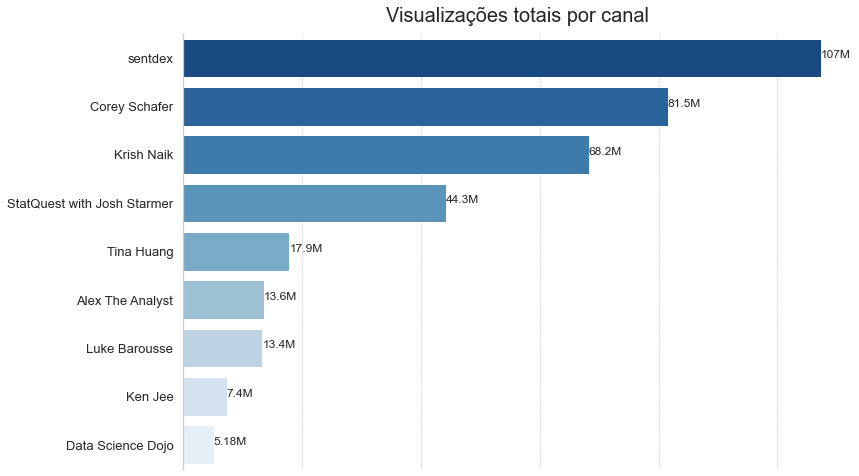

In [9]:
plt.figure(figsize=(12,8))

ax = sns.barplot(data=stats_canais, 
                x='views', 
                y='channelName',
                order=stats_canais.sort_values('views', ascending=False).channelName,
                palette='Blues_r')

   
show_values(ax, orient='h')

sns.despine(bottom=True)
ax.set_title("Visualizações totais por canal", fontsize=20, pad=12)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=13, bottom=False)
ax.set(xticklabels=[])


plt.show()

<p>Abaixo temos os ranking considerando o total de visualizações de cada canal. O ordem é relativamente similar em relação ao ranking de inscritos. Sentdex e Corey Schafer continuam como os dois canais mais populares considerando visualizações e inscritos. Interessante notar que alguns canais tem mais visualizações porém, menos inscritos, o oposto também acontece. Por exemplo, o canal de Krish Naik tem um número maior de inscritos do que o canal de StatQuest, no entanto tem uma considerável a mais de visualizações em seus vídeos.</p>

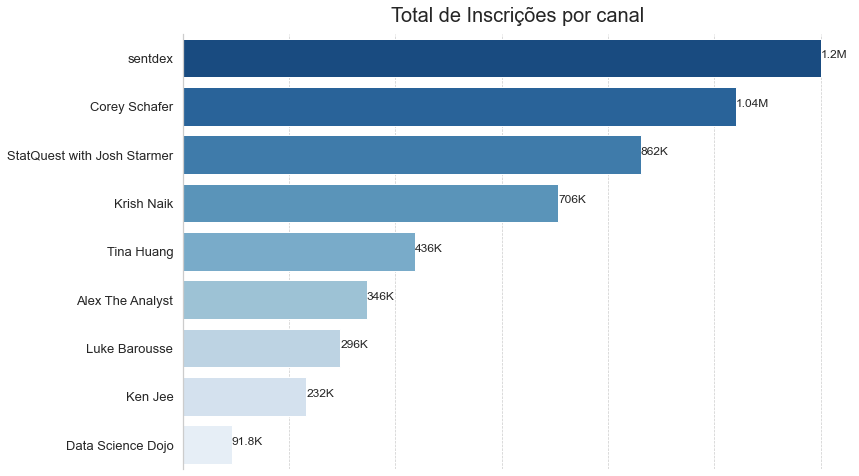

In [10]:
plt.figure(figsize=(12,8))

ax = sns.barplot(data=stats_canais, 
                x='subscribers', 
                y='channelName',
                order=stats_canais.sort_values('subscribers', ascending=False).channelName,
                palette='Blues_r')

   
show_values(ax, orient='h')

sns.despine(bottom=True)
ax.set_title("Total de Inscrições por canal", fontsize=20, pad=12)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=13, bottom=False)
ax.set(xticklabels=[])


plt.show()

## Obtendo as estatísticas dos vídeos dos canais

Agora iremos obter as estatísticas dos vídeos e os comentários para todos os vídeos listados dos canais selecionados acima. Os erros encontrados abaixo se dão provavelmente ao fato dos comentários em determinado vídeo estarem desabilitados. No total, nos obtemos 4266 vídeos, conforme abaixo.

In [11]:
df_videos = pd.DataFrame()
df_comentarios = pd.DataFrame()

for canal in stats_canais['channelName']:
    print("Obtendo video infos do canal " + canal)
    playlist_id = stats_canais.loc[stats_canais.channelName == canal, 'playlistID'].iloc[0]
    video_ids = obtem_video_ids(youtube, playlist_id)
    
    dados_videos = obtem_detalhes_video(youtube, video_ids)
    
    dados_comentarios = obtem_comentarios_videos(youtube, video_ids)
    
    
    df_videos = df_videos.append(dados_videos, ignore_index=True)
    df_comentarios = df_comentarios.append(dados_comentarios, ignore_index=True)

Obtendo video infos do canal Krish Naik
Não foi possível obter os comentários para o video sjq1OhMzSSU
Obtendo video infos do canal StatQuest with Josh Starmer
Não foi possível obter os comentários para o video ZKTG3Zjfmc8
Não foi possível obter os comentários para o video BgxBEKhaqyQ
Obtendo video infos do canal Alex The Analyst
Obtendo video infos do canal Data Science Dojo
Não foi possível obter os comentários para o video eghp7pBuV3E
Não foi possível obter os comentários para o video RA4VUmivDiw
Não foi possível obter os comentários para o video ceTSkDWzlE8
Não foi possível obter os comentários para o video Ams4sEn50cw
Não foi possível obter os comentários para o video 4NcNYVNUeog
Não foi possível obter os comentários para o video 1v-Ca9iyo0k
Não foi possível obter os comentários para o video Rcv1O-tv1n8
Não foi possível obter os comentários para o video buRkFmE_HjA
Não foi possível obter os comentários para o video 2FxWwK0djdk
Não foi possível obter os comentários para o video LDT

In [13]:
df_videos.shape

(4275, 13)

In [14]:
df_comentarios.shape

(4258, 2)

In [14]:
# Salvando dados em CSV para uma futura utilização
df_videos.to_csv('video_data_top10_channels.csv')
df_comentarios.to_csv('comments_data_top10_channels.csv')

# Preprocessing & Feature engineering

Para utilizar os dados na análise precisamos fazer alguns ajustes. Primeiro, reformatar algumas colunas, especialmente de data e tempo como "publishedAt" e "duration". Além disso, seria interessante enriquecer os dados com algumas novas colunas que podem ser úteis no entendimento das características dos vídeos. 

## Checando valores nulos

In [15]:
df_videos.isnull().any()

video_id          False
channelTitle      False
title             False
description        True
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

Os vídeos foram publicados entre 2013 e 2022, até ai nenhuma inconsistência nos dados de data.

In [16]:
df_videos.publishedAt.sort_values().value_counts()

2013-06-28T02:54:45Z    11
2014-07-30T02:52:13Z    10
2019-07-03T05:15:02Z     6
2016-05-03T23:06:55Z     5
2013-06-28T02:54:44Z     5
                        ..
2020-11-24T13:46:53Z     1
2022-05-04T14:37:41Z     1
2021-08-24T11:30:01Z     1
2021-01-11T16:40:13Z     1
2020-03-23T19:47:33Z     1
Name: publishedAt, Length: 4217, dtype: int64

No próximo passo, checamos se os tipos de dados estão coerentes. Após a checagem notamos a necessidade de alteração de algumas colunas como "viewCount", "likeCount", etc. para o tipo numérico. Abaixo promovemos as alterações.

In [17]:
num_cols = ['viewCount','likeCount','favouriteCount','commentCount']
df_videos[num_cols] = df_videos[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)

## Enriquecendo os dados

Para uma análise mais precisa, adicionamos as seguintes colunas ao dataset:
<br></br>

* publishedDayName - dia da semana da publicação do vídeo.
<br></br>
* durationSecs - duração dos vídeos em segundos. O formato da coluna duration era string e de difícil utilização.
<br></br>
* tagsCount - Número de tags associadas ao vídeo.
<br></br>
* likeRation e commentRation - Razão entre o número de comentários e likes por 1000 visualizações.
<br></br>
* titleLenght - Número de caracteres no título do vídeo.

In [18]:
df_videos['publishedAt'] = df_videos['publishedAt'].apply(lambda x: parse(x))
df_videos['publishedDayName'] = df_videos['publishedAt'].apply(lambda x: x.strftime("%A"))

df_videos['durationSecs'] = df_videos['duration'].apply(lambda x: isodate.parse_duration(x))
df_videos['durationSecs'] = df_videos['durationSecs'].astype('timedelta64[s]')

# df_videos['tagsCount'] = df_videos['tags'].apply(lambda x: 0 if pd.isnull(x) else len(x.split(',')))
df_videos['tagsCount'] = df_videos['tags'].apply(lambda x: 0 if x is None else len(x))

df_videos['likeRatio'] = df_videos['likeCount'] / df_videos['viewCount'] * 1000
df_videos['commentRatio'] = df_videos['commentCount'] / df_videos['viewCount'] * 1000

df_videos['titleLength'] = df_videos['title'].apply(lambda x: len(x))

# EDA

## Distribuição de visualizações por canal

<p>Com as estatísticas de todos os canais podemos ver como as visualizações são distribuidas por canal. Alguns canais tem muitas visualizações em um vídeo e no restante dos vídeos nem tanto. Outros canais tem uma distribuição mais uniforme de visualizações por vídeo. Isto pode ser observado nos canais de Luke Barousse, Corey Schafer e Tina Huang, que tem uma alta variância de visualizações, sugerindo que tem alguns vídeos que se tornaram virais. Alex The Analyst, Data Science Dojo e Ken Jee tem menos visualizações na soma absoluta, mas tem mais consistência dos números em seus vídeos. </p>

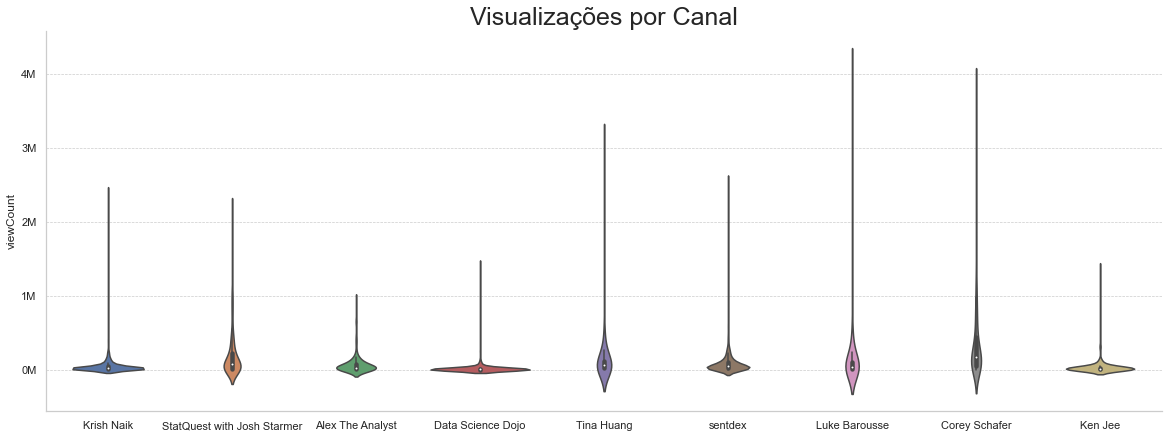

In [19]:
plt.figure(figsize=(20,7))
ax = sns.violinplot(data=df_videos,
                    x = 'channelTitle',
                    y = 'viewCount')
ax.set_title('Visualizações por Canal', fontsize=25)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M'))
sns.despine()
plt.show()

## Mais interações refletem mais visualizações?

<p>Primeiro checamos se existe correlação entre a quantidade de visualizações e interações (curtidas e comentários). No gráfico abaixo, esta correlação pode ser observada, principalmente entre o número de likes e as visualizações. No entanto é esperado que quanto maior as visualizações, mais pessoas tendem a gostar de conteúdo e interagir com o vídeo na forma de curtida ou comentário. Para corrigir este fator, plotou-se os relacionamentos novamente porém, com comentários e curtidas divididos por mil visualizações (commentRatio e likeRatio).</p>

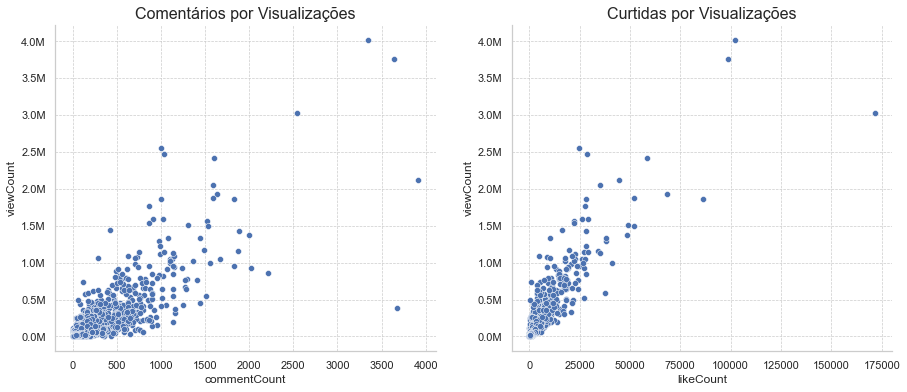

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(data=df_videos, x="commentCount", y="viewCount", ax=ax[0])
sns.scatterplot(data=df_videos, x="likeCount", y="viewCount", ax=ax[1])
sns.despine()
ax[0].set_title("Comentários por Visualizações", fontsize=16)
ax[1].set_title("Curtidas por Visualizações", fontsize=16)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
plt.show()

<p>Abaixo temos as correlações por valores de comentários e curtidas corrigidas por mil visualizações</p>

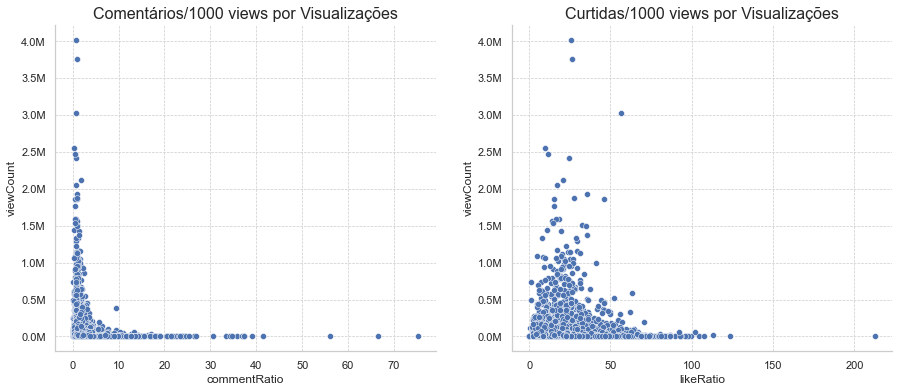

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(data=df_videos, x="commentRatio", y="viewCount", ax=ax[0])
sns.scatterplot(data=df_videos, x="likeRatio", y="viewCount", ax=ax[1])
sns.despine()
ax[0].set_title("Comentários/1000 views por Visualizações", fontsize=16)
ax[1].set_title("Curtidas/1000 views por Visualizações", fontsize=16)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
plt.show()

<p>Após corrigir para o número absoluto de visualizações, a correlação entre as variáveis fica menos evidente. A relação entre comentários e visualizações desaparece por completo: muitos vídeos tem milhões de visualizações e poucos comentários, enquanto outros vídeos tem poucas visualizações e mais interações. No entanto, é compreensível que fazer um comentário requer mais esforço do que uma visualização e uma curtida.<p>
    
<p>Como na correlação entre curtidas e visualização, mesmo após a correção para o número absoluto, ainda é possível perceber uma correlação positiva entre as variáveis, o que significa que mais quanto mais visualizações tem vídeo, mais pessoas apertam o botão de gostei proporcionalmente. Isso pode ser suportado por uma ideia de aprovação social, ou seja, quanto mais likes um vídeo tem, maior é a percepção positiva do vídeo, que faz com que as pessoas dêem mais likes.</p>

## A duração do vídeo impacta no núemro de interações (curtidas / comentários)?

<p>Abaixo temos um histograma com a distibuição da duração dos vídeos. A maioria se situa entre 300 a 1200 segundos, o que corresponde entre 5 a 20 minutos. Com o propósito de melhorar a visualização houve uma limitação de duração de até 10.000 segundos, pois alguns vídeos são realmente longos (provavelmente transmissões ao vivo). </p>

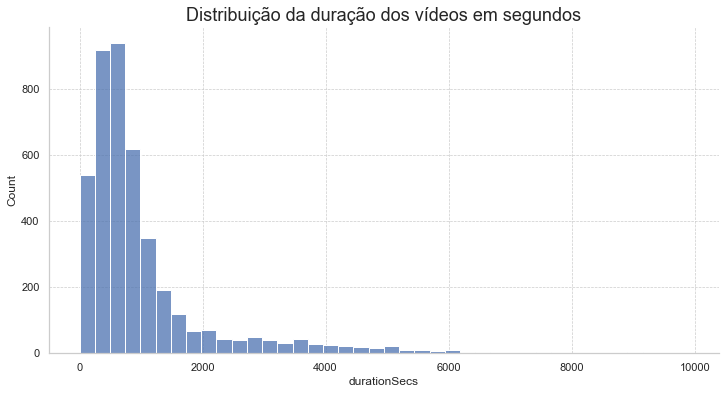

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_videos[df_videos['durationSecs'] < 10000], x='durationSecs', bins=40)
plt.title("Distribuição da duração dos vídeos em segundos", fontsize=18)
sns.despine()

<p>Abaixo temos um gráfico de dispersão entre interações (curtidas e comentários) e visualizações por duração dos vídeos. O que pode ser percebido é que vídeos com duração menor tendem a ter mais interaçãoes e visualizações.</p>

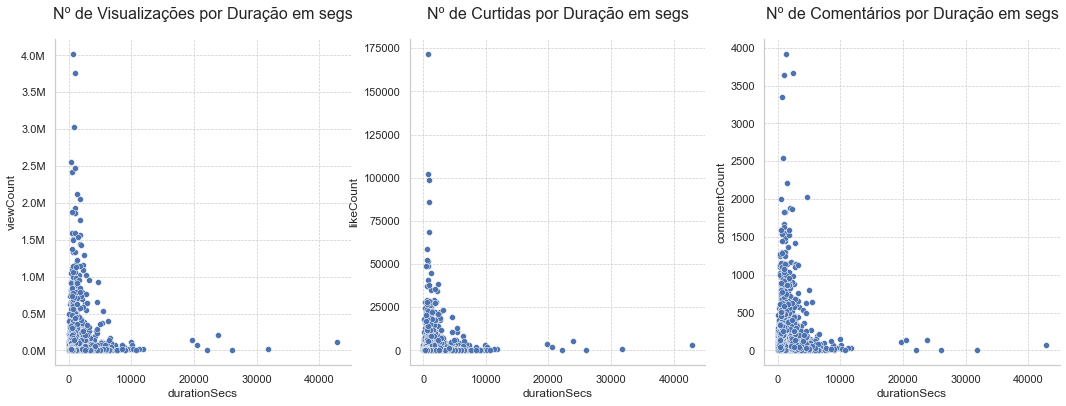

In [23]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.scatterplot(data=df_videos, x="durationSecs", y="viewCount", ax=ax[0])
sns.scatterplot(data=df_videos, x="durationSecs", y="likeCount", ax=ax[1])
sns.scatterplot(data=df_videos, x='durationSecs', y='commentCount', ax=ax[2])
ax[0].set_title("Nº de Visualizações por Duração em segs", fontsize=16, pad=20)
ax[1].set_title("Nº de Curtidas por Duração em segs", fontsize=16, pad=20)
ax[2].set_title("Nº de Comentários por Duração em segs", fontsize=16, pad=20)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
sns.despine()
plt.show()

## O tamanho do título importa?

<p>Não existe correlação clara entre o tamanho do título do vídeo e o número de visualizações, mas a maioria dos títulos tem entre 30 e 70 caracteres.</p>

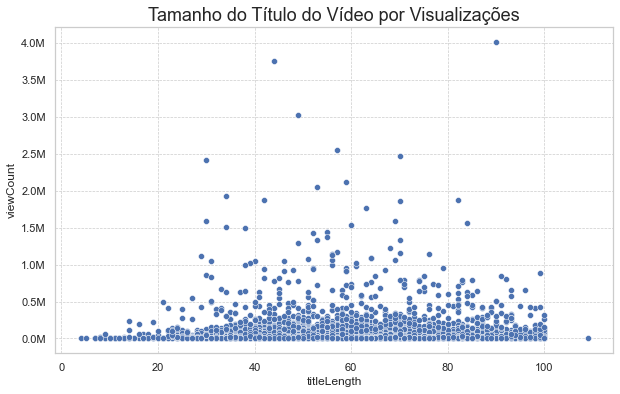

In [24]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=df_videos, x='titleLength', y='viewCount')
plt.title("Tamanho do Título do Vídeo por Visualizações", fontsize=18)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
plt.show()

## Nuvem de palavras para o título dos vídeos

<p>Abaixo temos uma nuvem de palavras com os principais termos utilizados nos títulos dos vídeos. Retiram-se palavras que sozinhas não tem significado no inglês como: “a”, “an”, “the”, etc. Estes termos são chamados stopwords.</p>

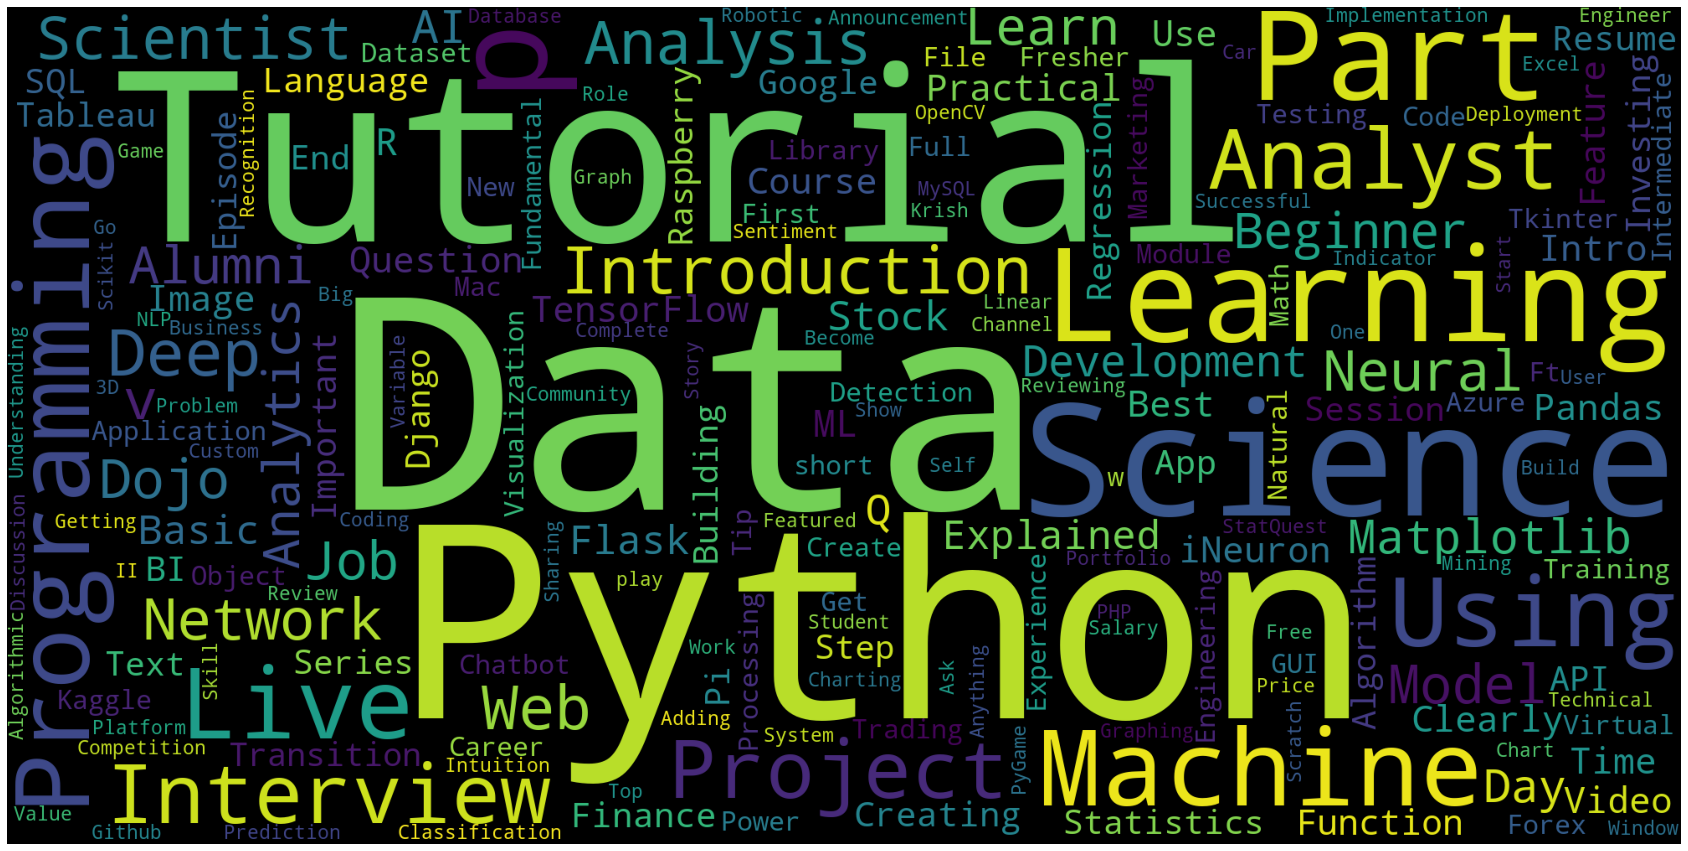

In [25]:
stopwords = nltk.corpus.stopwords.words('english')

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");


all_title = [item for item in df_videos['title']]
all_title_str = " ".join(all_title)

wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', stopwords=stopwords, collocations=False).generate(all_title_str)

plot_cloud(wordcloud)

<p>Como podemos ver os termos mais citados são "Data", "Tutorial", "Python", "Science", "Machine", "Learning", "Analyst". Dado o tema que os canais se propõem a produzir conteúdo o resultado é o esperado.</p>

## Número de tags por visualizações

<p>O gráfico abaixo demonstra que a maioria dos vídeos tem entre 5 e 30 tags. A correlação entre número de tags e visualizações não parece ser clara, porém, muitas tags ou poucas tags parecem estar relacionadas ao baixo número de visualizações.</p>

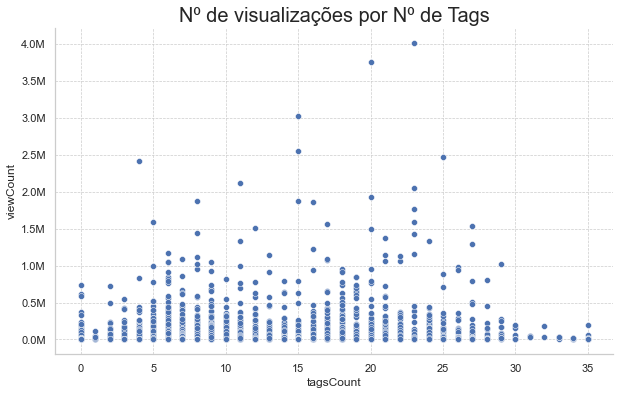

In [26]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=df_videos, x='tagsCount', y='viewCount')
ax.set_title("Nº de visualizações por Nº de Tags", fontsize=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
sns.despine()
plt.show()

## Qual dia da semana tem mais vídeos publicados?

<p>De acordo com o gráfico abaixo mais vídeos são publicados na segunda-feira e sexta-feira e menos vídeos são publicados no final de semana. Isso pode ocorrer pela natureza do nicho de ciência de dados, que tem um caratér profissional e tende a ser consumido durante a semana. Mas, olhando pela a perspectiva do criador de conteúdo, provavelmente alguns utilizam o final de semana para produzir os vídeos e preferem publica-los no início da semana ou utilizam o tempo livre durante a semana e preferem publicar o conteúdo na sexta-feira.</p>

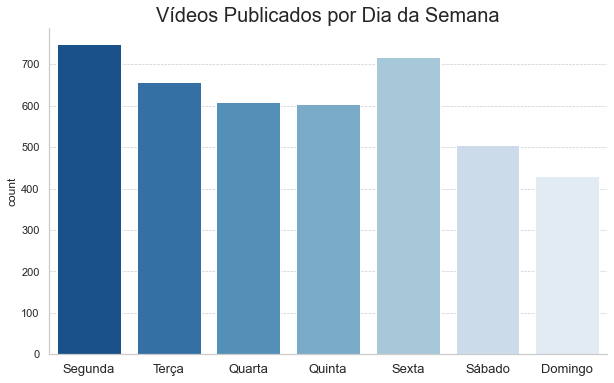

In [27]:
plt.figure(figsize=(10,6))
dias_semana = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dias_semana_pt = ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado','Domingo']
ax = sns.countplot(data=df_videos, x='publishedDayName', order=dias_semana, palette='Blues_r')
ax.set_title("Vídeos Publicados por Dia da Semana", fontsize=20)
ax.set_xlabel("")
ax.set_xticklabels(dias_semana_pt, fontsize=13)
sns.despine()
plt.show()

## Nuvem de palavras dos cometários dos vídeos

<p>Abaixo temos os termos mais utilizados nos comentários dos vídeos.</p>

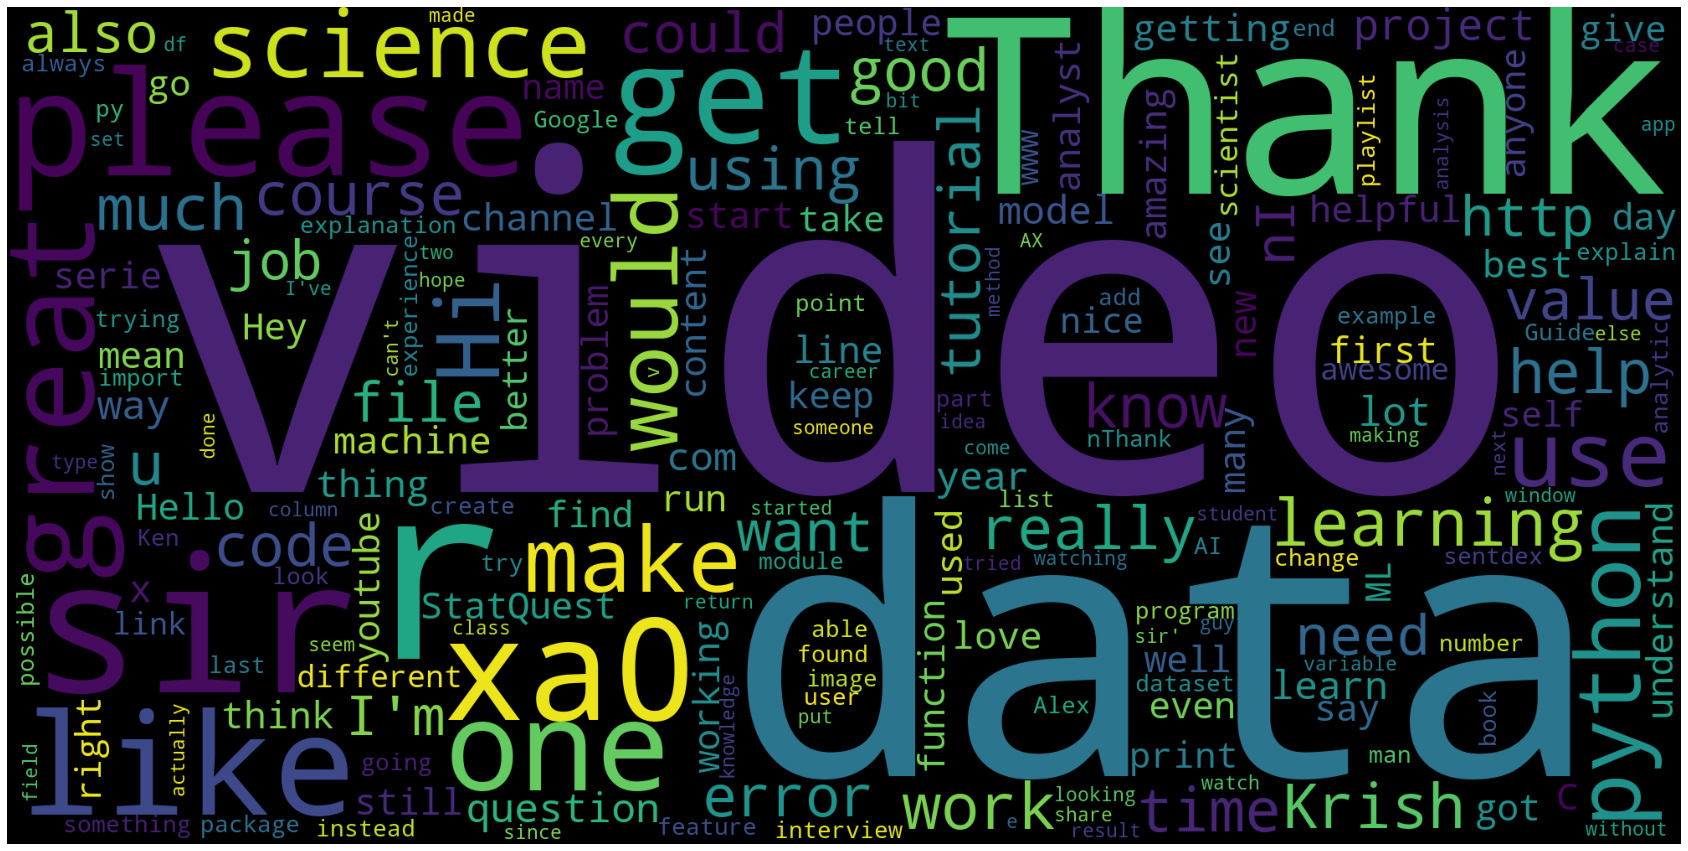

In [28]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['n'])

all_summary = [item for item in df_comentarios['comentarios']]
all_summary_str = " ".join(all_summary)

wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', stopwords=stopwords, collocations=False).generate(all_summary_str)

plot_cloud(wordcloud)

<p>Além das palavras mais óbvias "video" e "data", temos termos positivos como "thank", "great", "amazing", "awesome". Interessante também notar a frequência da palavra "please", provavelmente requisitando um tema de vídeo uma a solução de uma dúvida.</p>

# Conclusões

<p>Neste projeto exploramos os dados dos 9 canais mais populares em língua inglesa sobre Data Science/Data Analysis e obtivemos insights interessantes para quem quer criar um canal no YouTube sobre este nicho ou semelhante:</p>

* Quanto mais interações (curtidas e comentários) um vídeo tem, maior o número de visualizações proporcionalmente. Vale dizer que o que se percebe é uma correlação, que, diferente de uma relação causalidade, pode ocorrer nos dois sentidos. Com o fator de correção de interações por mil visualizações, percebemos o efeito de aprovação social das interações, os usuários tendem a interagir com conteúdos com alto número de interações, proporcionalmente.
<br/><br/>
* A maioria dos vídeos tem entre 5 e 30 tags.
<br/><br/>
* Os vídeos com maior número de visualizações tendem a ter em média um título contendo entre 30 a 70 caracteres. Vídeos com poucos ou muitos caracteres aparentam sofrer com baixo número de visualizações.
<br/><br/>
* Normalmente os vídeos são publicados nas Segundas e Sextas. O final de semana, particularmente, tem menos publicações de conteúdo.
<br/><br/>
* Os termos chaves dos comentários são relativamente positivos. Foi interessante notar o alto uso da palavra "please", sugerindo um potencial de conteúdo não explorado.

<b>Limitações do projeto</b>
<p>Os insights obtidos deste projeto devem levar em conta alguns fatores:</p>

* O número de vídeos é relativamente pequeno (o dataset tem menos de 4,3 mil registros).
<br></br>
* Por limitação da API do Youtube, só foi possível obter a íntegra de 10 comentários por vídeo, ou seja, a nuvem de palavras pode não refletir a totalidade dos comentários.
<br></br>
* Existes muitos fatores que não puderam ser levados em conta durante a análise, como a estratégia de marketing de cada criador de conteúdo e muitos efeitos aleatórios que podem afetar o sucesso de um vídeo.

<b>Ideia para um futuro projeto</b>
<p>Para expandir a análise dos dados podemos:</p>

* Expandir a análise para canais com menos relevância no nicho de ciência de dados.
<br></br>
* Fazer uma análise de sentimento com os comentários e encontrar quais vídeos tem mais e menos comentários positivos.
<br></br>
* Fazer uma análise das perguntas feitas nos comentários para encontrar lacunas nos conteúdos dos criados.
<br></br>
* Aplicar a análise em outros nichos(vlogs ou canais de games) e fazer uma comparação dos resultados, identificando padrões que independem do tipo de conteúdo dos vídeos.

# Referências

[1] Youtube API. Disponível em https://developers.google.com/youtube/v3

[2] Função de conversão da duração dos vídeos. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] Configuração de acesso à API do Youtube. https://youtu.be/D56_Cx36oGY